In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report,f1_score, accuracy_score,roc_curve,roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import pickle

In [2]:
df = pd.read_csv('data/churndata.csv')
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Splitting data into features and target

In [3]:
df_features = df.iloc[:,:-1]
df_target = df.iloc[:,-1]

Splitting dataset into training and testing to test the model performance

In [4]:
# splitting the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(df_features, df_target, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

### Feature Selection

Selecting only the features that are necessary for model to predict.  We can remove customer id since this is random generated for unique id

In [5]:
df_features = df_features.drop('customer_id', axis=1)

In [6]:
numerical_columns = ["credit_score", "age","tenure","balance","products_number","credit_card","active_member","estimated_salary"]
categorical_columns = ["gender","country"]

In [7]:
num_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]
)

cat_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("one_hot_encoder", OneHotEncoder()),
        ("scaler", StandardScaler(with_mean=False))
    ]

)

preprocessor = ColumnTransformer(
    [
        ("num_pipeline", num_pipeline, numerical_columns),
        ("cat_pipelines", cat_pipeline, categorical_columns)

    ]
)

In [8]:
X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)

In [9]:
os.makedirs('pickle', exist_ok=True)
preprocessor_file_path = os.path.join("pickle", "preprocessor.pkl")

with open(preprocessor_file_path, "wb") as file:
    pickle.dump(preprocessor, file)

In [10]:
rus = RandomUnderSampler(random_state=42)
print(f"Before undersampling: {sum(y_train==0)}, {sum(y_train==1)}")
X_train, y_train = rus.fit_resample(X_train, y_train)
print(f"After undersampling: {sum(y_train==0)}, {sum(y_train==1)}")

Before undersampling: 5709, 1491
After undersampling: 1491, 1491


### Preliminary modelling

In [11]:
#defining all necessary models for classification

def getBaseModels():
    baseModels = []
    baseModels.append(('LR', LogisticRegression()))
    baseModels.append(('XGB', XGBClassifier()))
    baseModels.append(('DT', DecisionTreeClassifier()))
    baseModels.append(('NB', GaussianNB()))
    baseModels.append(('SVC', SVC(probability=True)))
    baseModels.append(('RF', RandomForestClassifier()))
    return baseModels

In [12]:
#using k-fold on training data to evaluate the model accuracy

def validatemodels(df_feature,df_target):
    models = getBaseModels()
    modelScores = []
    modelStd = []
    modelNameList = []
    for name, model in models:
        cv = KFold(n_splits=10, random_state=42, shuffle=True)
        cv_results = cross_val_score(model,X_train, y_train,cv=cv,scoring="accuracy", error_score="raise")
        modelScores.append(cv_results.mean()*100)
        modelNameList.append(name)
        modelStd.append(cv_results.std())

    modelScores = np.round(modelScores, 2)
    modelStd = np.round(modelStd, 2)
    modelResult = pd.DataFrame({
        'Models': modelNameList,
        'Scores': modelScores,
        'σ': modelStd
    })
    print(modelResult.sort_values(by=['Scores', 'σ'], ascending=False))
    #visualing the models performance
    plt.title('Algorithm Comparison')
    ax=sns.barplot(y=modelScores, x=modelNameList)
    ax.bar_label(ax.containers[0])
    plt.show()

  Models  Scores     σ
4    SVC   76.26  0.02
5     RF   75.76  0.02
1    XGB   74.55  0.01
3     NB   70.99  0.03
0     LR   70.35  0.03
2     DT   69.78  0.02


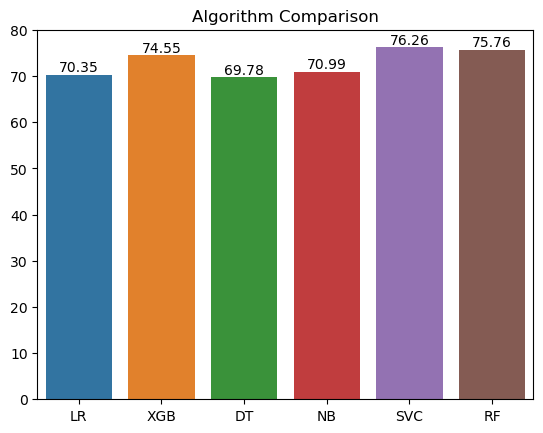

In [13]:
validatemodels(X_train,y_train)

### Model Tuning

Tuning the hyperparameters of the model to increase model's performance and to make the prediction more generalizable. 
Using GridSearchCV, finding optimal parameters from given set

In [16]:
# function to use gridsearch for all the models

def gridSearchFunction(model,name, params, cv, X_train, y_train, X_val, y_val):
    gs = GridSearchCV(model, params, scoring='accuracy', n_jobs=-1, cv=cv)
    result = gs.fit(X_train, y_train)
    best_model = result.best_estimator_
    y_predict = best_model.predict(X_val)
    accuracy = accuracy_score(y_val, y_predict)
    y_pred_proba = best_model.predict_proba(X_val)[:, 1]
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    f1 = f1_score(y_val, y_predict)
    print(name)
    print(classification_report(y_val, y_predict))
    print('AUC score: ', np.round(roc_auc,2))
    print('Best Hyperparameters: ', result.best_params_)
    return gs.best_params_

In [17]:
# Random Forest
cv = 5

max_depth = [3, 5, 6, 7, 8]
max_features = [2,4,6,7,8,9]
n_estimators = [50,100]
min_samples_split = [3, 5, 6, 7]

param_grid = dict(max_depth=max_depth, max_features=max_features, n_estimators=n_estimators,min_samples_split=min_samples_split)

model = RandomForestClassifier()
bestParams = gridSearchFunction(model,'Random Forest', param_grid, cv, X_train, y_train, X_val, y_val)

Random Forest
              precision    recall  f1-score   support

           0       0.93      0.80      0.86       647
           1       0.48      0.76      0.58       153

    accuracy                           0.79       800
   macro avg       0.70      0.78      0.72       800
weighted avg       0.85      0.79      0.81       800

AUC score:  0.87
Best Hyperparameters:  {'max_depth': 8, 'max_features': 8, 'min_samples_split': 7, 'n_estimators': 50}


In [18]:
# # SVC

# C = [1, 5, 10, 11, 14, 15, 18, 19, 20]
# kernel = ['linear', 'poly', 'rbf', 'sigmoid']
# gamma = ['scale', 'auto']
# degree = [4, 5, 10, 20]
# param_grid = dict(C = C, kernel= kernel,gamma=gamma,degree=degree)

# model = SVC(probability=True)
# bestParams = gridSearchFunction(model, 'SVC',param_grid, cv, X_train, y_train, X_val, y_val)

our primary objective is to predict customers who are likely to churn. This will allow me to implement specific strategies or schemes to prevent churn. Therefore, the recall measures on the positive class (churned customers) hold greater significance to me than the overall accuracy score of the model.

In [19]:
# Initializing the model using the parameters obtained through hyperparameter tuning.

model = RandomForestClassifier(max_depth = 8, max_features= 8, min_samples_split= 7, n_estimators= 50)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, max_features=8, min_samples_split=7,
                       n_estimators=50)

Testing model performance on the test dataset

In [20]:
X_test = preprocessor.transform(X_test)

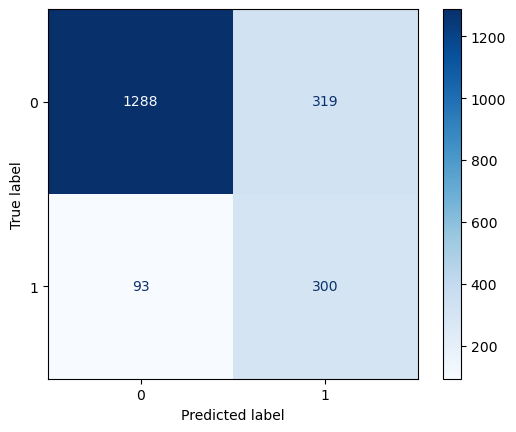

In [21]:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Blues')

In [22]:
model_file_path = os.path.join("pickle", "model.pkl")

with open(model_file_path, "wb") as file:
    pickle.dump(model, file)